In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
def display(gambar, titel,rows,columns):
    fig = plt.figure(figsize=(3*columns, rows*2)) 
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1) 
        plt.imshow(gambar[i], cmap='gray')
        plt.axis('off') 
        plt.title(titel[i])

In [3]:
def insertGambar(folder,banyakGambar):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    for label in tqdm((os.listdir(folder))):
        datalabel.append(label)
        i=0
        for filename in (os.listdir(folder+label)):
            img = plt.imread(os.path.join(folder+label,filename))
            if img is not None:
                filenames.append(filename)
                path.append(label)
                data.append(img)
                i+=1
            if i==banyakGambar:
                break
    print(datalabel)
    return data, filenames, datalabel, path

In [4]:
n = 100
data, filenames,label, path = insertGambar("data/",n) 

100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


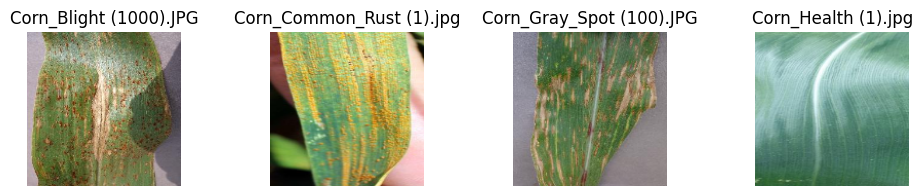

In [9]:
display([data[0],data[100],data[200],data[300]],[filenames[0],filenames[100],filenames[200],filenames[300]],1,4)

In [5]:
def resizeImage(data, ukuran):
    resizeData = []
    for img in tqdm(data):
        resized_img = cv.resize(img, (ukuran, ukuran))
        resizeData.append(resized_img)    
    return resizeData

In [6]:
data = resizeImage(data, 150)

100%|██████████| 400/400 [00:00<00:00, 7864.33it/s]


In [7]:
def grayscale(data):
    grayData = []
    for img in tqdm(data):
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

In [8]:
preprocessing1 = grayscale(data)

100%|██████████| 400/400 [00:00<00:00, 20917.14it/s]


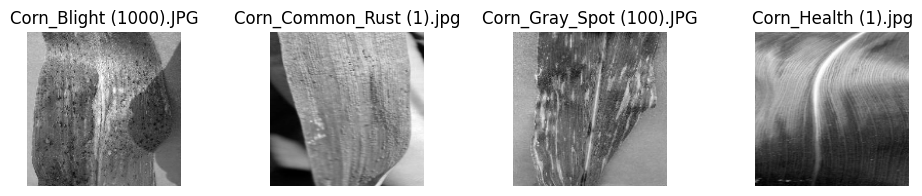

In [10]:
display([preprocessing1[0],preprocessing1[100],preprocessing1[200],preprocessing1[300]],[filenames[0],filenames[100],filenames[200],filenames[300]],1,4)

In [157]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

In [158]:
def derajat(img, derajat):
    max = int(np.max(img))
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

In [159]:
def GLCM(image):
    hasil = []
    for img in tqdm(image):
        if np.min(img) < 0:
            continue
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil 

In [161]:
hasilGLCM = GLCM(preprocessing1)

100%|██████████| 400/400 [00:56<00:00,  7.07it/s]


In [162]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil
def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i*data[i,j]
            mean[1] += j*data[i,j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += pow(i-mean[0],2)*data[i,j]
            std[1] += pow(j-mean[1],2)*data[i,j]
    std[0] = math.sqrt(std[0])
    std[1] = math.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i-mean[0])*(j-mean[1])*data[i,j]/(std[0]*std[1])
    return hasil
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [163]:
def ekstraksi(data):
    result = []
    for i in tqdm(range(len(data))):
        extracted_data = []
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
                asm_val = asm(data[i][j])
                extracted_data.append(asm_val)
                entropy_val = entropy(data[i][j])
                extracted_data.append(entropy_val)
        result.append(extracted_data)
    return result

In [164]:
hasilEkstraksi = ekstraksi(hasilGLCM)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [04:09<00:00,  1.61it/s]


In [166]:
for i in range (len(hasilEkstraksi)):
    hasilEkstraksi[i].append(path[i])

In [167]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = []
for fitur in fiturs:
    headers.extend([f'{fitur}_0', f'{fitur}_45', f'{fitur}_90', f'{fitur}_135'])
for angle in angles:
    headers.extend([f'asm_{angle}', f'entropy_{angle}'])
headers.append('Path')
df = pd.DataFrame(hasilEkstraksi, columns=headers)
df.to_csv('sebelumPreprocessing.csv', index=False)

In [168]:
df.head()

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,Path
0,485.037763,518.396514,330.462819,519.208369,15.308904,15.992928,12.641521,16.006892,0.098923,0.088366,...,0.836111,0.000180,9.045917,0.000169,9.085644,0.000205,8.915672,0.000167,9.091573,Blight
1,143.039821,139.927210,111.398971,189.074411,7.055213,7.228683,6.380716,8.388046,0.261784,0.210653,...,0.851611,0.000750,7.867193,0.000594,7.956502,0.000657,7.851935,0.000549,8.059850,Blight
2,137.245772,108.642449,131.216107,201.383181,6.735526,6.429485,6.799105,8.313950,0.268169,0.221547,...,0.763285,0.001207,7.582689,0.000985,7.627662,0.001045,7.636607,0.000905,7.772802,Blight
3,126.541029,159.534390,65.367875,130.441151,6.676600,7.663844,4.918121,6.988334,0.260508,0.205324,...,0.897185,0.001299,7.638462,0.000948,7.809502,0.001185,7.498465,0.000976,7.754421,Blight
4,260.908904,257.452998,96.490962,287.246025,11.851812,11.795685,6.877808,12.525607,0.110849,0.101491,...,0.885958,0.000198,8.826674,0.000192,8.835696,0.000306,8.398882,0.000183,8.882473,Blight


In [169]:
df = pd.read_csv('sebelumPreprocessing.csv')
x = df.drop('Path', axis=1)
y = df['Path']

In [170]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=42)

In [171]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [172]:
knn = KNeighborsClassifier()
svm = SVC()
rf = RandomForestClassifier()

knn.fit(xTrain, yTrain)
svm.fit(xTrain, yTrain)
rf.fit(xTrain, yTrain)

yPredKnn = knn.predict(xTest)
yPredSvm = svm.predict(xTest)
yPredRf = rf.predict(xTest)

acc_knn = accuracy_score(yTest, yPredKnn)
precision_knn = precision_score(yTest, yPredKnn, average='weighted')
recall_knn = recall_score(yTest, yPredKnn, average='weighted')
f1_knn = f1_score(yTest, yPredKnn, average='weighted')

acc_svm = accuracy_score(yTest, yPredSvm)
precision_svm = precision_score(yTest, yPredSvm, average='weighted')
recall_svm = recall_score(yTest, yPredSvm, average='weighted')
f1_svm = f1_score(yTest, yPredSvm, average='weighted')

acc_rf = accuracy_score(yTest, yPredRf)
precision_rf = precision_score(yTest, yPredRf, average='weighted')
recall_rf = recall_score(yTest, yPredRf, average='weighted')
f1_rf = f1_score(yTest, yPredRf, average='weighted')

hasil = pd.DataFrame()
hasil['Model'] = ['KNN', 'SVM', 'Random Forest']
hasil['Accuracy'] = [acc_knn, acc_svm, acc_rf]
hasil['Precision'] = [precision_knn, precision_svm, precision_rf]
hasil['Recall'] = [recall_knn, recall_svm, recall_rf]
hasil['F1-Score'] = [f1_knn, f1_svm, f1_rf]
print(hasil)



           Model  Accuracy  Precision    Recall  F1-Score
0            KNN  0.616667   0.651244  0.616667  0.624228
1            SVM  0.666667   0.685959  0.666667  0.668659
2  Random Forest  0.666667   0.687834  0.666667  0.667927
